---
---
# Convolutional Neural Network - Transfer Learning
---
---

The purpose of this notebook is to explain the concept of transfer learning

## Libraries Imports

In [53]:
#import tensorflow and keras
import tensorflow as tf
from keras import layers, models, datasets, utils
from keras.applications import ResNet50, MobileNetV3Small, InceptionV3, VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.models import Model

#import pandas and matplotlib for accurcy visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import time
import random
import os

# Set the random seed for reproducibility
random.seed(42)
np.random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)
tf.random.set_seed(42)

## Helper Functions

In [54]:
def show_history(history, type='loss'):
# Assuming 'history' is the output from the model.fit call
  train_loss = history.history['loss']
  val_loss = history.history['val_loss']
  train_accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']
  epochs = range(1, len(train_loss) + 1)

  fig = go.Figure()

  if type == 'loss':
    # Add traces for training and validation loss
    fig.add_trace(go.Scatter(x=list(epochs), y=train_loss, mode='lines+markers', name='Training Loss'))
    fig.add_trace(go.Scatter(x=list(epochs), y=val_loss, mode='lines+markers', name='Validation Loss'))
    # Add titles and labels
    fig.update_layout(title='Training and Validation Loss',
                      xaxis_title='Epochs',
                      yaxis_title='Loss',
                      template='plotly_dark')
  else:
    # Add traces for training and validation loss
    fig.add_trace(go.Scatter(x=list(epochs), y=train_accuracy, mode='lines+markers', name='Training Accuracy'))
    fig.add_trace(go.Scatter(x=list(epochs), y=val_accuracy, mode='lines+markers', name='Validation Accuracy'))
    # Add titles and labels
    fig.update_layout(title='Training and Validation Accuracy',
                      xaxis_title='Epochs',
                      yaxis_title='Accuracy',
                      template='plotly_dark')


  # Show the plot
  fig.show()

## Loading Data

The above method truly shines when used with big images and especially multi-channel images

**The CIFAR-100** dataset is a well-known dataset used in machine learning and computer vision for evaluating image recognition algorithms. It is a more complex and diverse dataset compared to its counterpart, CIFAR-10, primarily due to the larger number of classes.

![Cifar100](https://datasets.activeloop.ai/wp-content/uploads/2022/09/CIFAR-100-dataset-Activeloop-Platform-visualization-image.webp)

>- CIFAR-100 contains 60,000 32x32 color images.
>- The images are divided into 100 classes, each containing 600 images.
>- The 100 classes are grouped into 20 superclasses.
>- Each superclass encompasses several classes that are more specific; for example, the "aquatic mammals" superclass includes classes like "beaver", "dolphin", and "otter".

 When you load a dataset using TensorFlow Datasets, you receive the data in the form of TensorFlow tf.data.Dataset objects. These objects encapsulate a complete data pipeline for loading and preprocessing data directly from TensorFlow's optimized binary format.

In [55]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

# Load the dataset and apply preprocessing
ds, ds_info = tfds.load('caltech101', with_info=True, as_supervised=True)

def preprocess(image, label):
    image = tf.image.resize(image, (128, 128))  # Resize images
    label = tf.one_hot(label, depth=ds_info.features['label'].num_classes)  # One-hot encode labels
    return image, label
# Get the number of classes
num_classes = ds_info.features['label'].num_classes

x = ds['train'].map(preprocess).batch(32).prefetch(tf.data.experimental.AUTOTUNE)
y = ds['test'].map(preprocess).batch(32).prefetch(tf.data.experimental.AUTOTUNE)



In [56]:
print(ds_info) # meta data on the dataset

tfds.core.DatasetInfo(
    name='caltech101',
    full_name='caltech101/3.0.2',
    description="""
    Caltech-101 consists of pictures of objects belonging to 101 classes, plus one
    `background clutter` class. Each image is labelled with a single object. Each
    class contains roughly 40 to 800 images, totalling around 9k images. Images are
    of variable sizes, with typical edge lengths of 200-300 pixels. This version
    contains image-level labels only. The original dataset also contains bounding
    boxes.
    """,
    homepage='https://doi.org/10.22002/D1.20086',
    data_dir='/root/tensorflow_datasets/caltech101/3.0.2',
    file_format=tfrecord,
    download_size=131.05 MiB,
    dataset_size=132.86 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/file_name': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=102),
    }),
    supervised_keys=('image', 'label'),
    disable_

## Modeling

In [57]:
# [Optional] Define the data augmentation pipeline
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
    layers.experimental.preprocessing.RandomContrast(0.2)
])

Begin with a traditional CNN Model for comparsion


In [58]:
model = models.Sequential([
     layers.Rescaling(1./255),  # Normalize the images
     layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
     layers.MaxPooling2D(2, 2),
     layers.Conv2D(64, (3, 3), activation='relu'),
     layers.MaxPooling2D(2, 2),
     layers.Conv2D(128, (3, 3), activation='relu'),
     layers.MaxPooling2D(2, 2),
     layers.Flatten(),
     layers.Dense(512, activation='relu'),
     layers.Dropout(0.5),
     layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.build((None, 128, 128, 3))  # `None` can be used for batch size to indicate flexibility
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_21 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 63, 63, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_22 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 30, 30, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_23 (Conv2D)          (None, 28, 28, 128)     

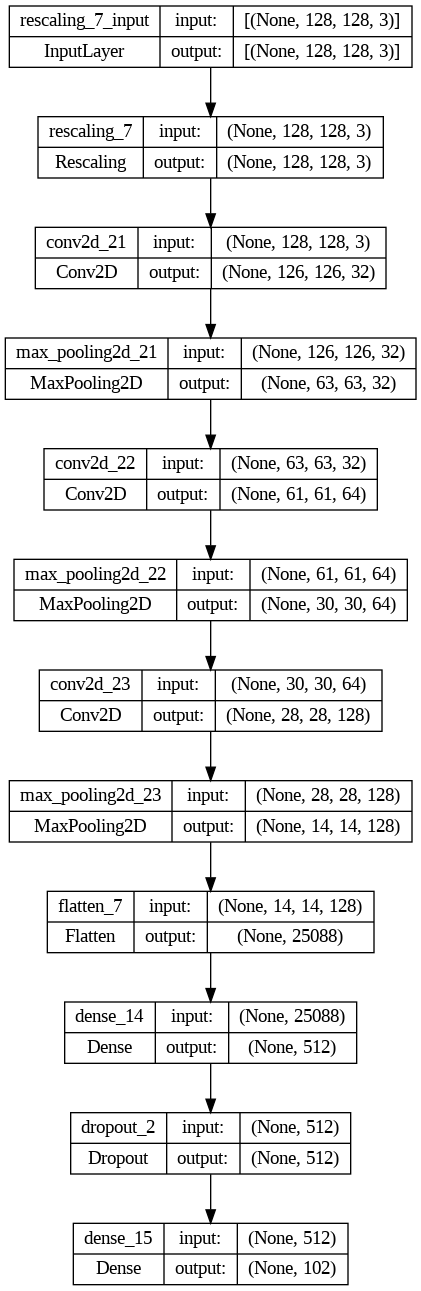

In [59]:
# Display the model's architecture
utils.plot_model(model, "CNN.png", show_shapes=True)

Note that the batch size used here is the batch size configurated perviously in the preprocessing pipeline so if your session crashes just put a smaller batch size though it will take a bit more time to run the model

In [60]:
# Apply data augmentation only to training data optional
# train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
# test_ds = test_ds.map(lambda x, y: (x, y))

# Train the model
history = model.fit(x, epochs=10, validation_data=y)

Epoch 1/10
96/96 [==============================] - 5s 37ms/step - loss: 4.6174 - accuracy: 0.0141 - val_loss: 4.5531 - val_accuracy: 0.0158
Epoch 2/10
96/96 [==============================] - 3s 30ms/step - loss: 4.4778 - accuracy: 0.0435 - val_loss: 4.2699 - val_accuracy: 0.1808
Epoch 3/10
96/96 [==============================] - 3s 30ms/step - loss: 4.1322 - accuracy: 0.1069 - val_loss: 3.6735 - val_accuracy: 0.3496
Epoch 4/10
96/96 [==============================] - 3s 34ms/step - loss: 3.7083 - accuracy: 0.1869 - val_loss: 3.1757 - val_accuracy: 0.4122
Epoch 5/10
96/96 [==============================] - 3s 33ms/step - loss: 3.2711 - accuracy: 0.2683 - val_loss: 2.8117 - val_accuracy: 0.4857
Epoch 6/10
96/96 [==============================] - 3s 31ms/step - loss: 2.9079 - accuracy: 0.3484 - val_loss: 2.5698 - val_accuracy: 0.5012
Epoch 7/10
96/96 [==============================] - 3s 31ms/step - loss: 2.5645 - accuracy: 0.4056 - val_loss: 2.4389 - val_accuracy: 0.5095
Epoch 8/10
96

In [ ]:
show_history(history)

## Transfer Learning

Transfer learning is a robust machine learning technique that leverages the knowledge gained while solving one problem and applying it to a different but related problem. For deep learning, this usually means using a pre-trained model developed for one task as the starting point for a model on another task. This is particularly useful in domains where labeled data are scarce or when training from scratch would be computationally prohibitive.

### Steps in Transfer Learning

1. **Choosing a Source Model**: The first step involves selecting an appropriate pre-trained model. This model should ideally be trained on a large dataset that is sufficiently similar or relevant to the new task. For instance, models trained on [ImageNet](https://www.image-net.org/) are popular choices due to the dataset's variety and size, which includes millions of images across thousands of categories.

2. **Preprocessing Your Data:**
   The target data must be processed to match the format used to train the source model. This includes tasks such as resizing images, applying the same normalization, and ensuring that the input specifications match (like image size and color channels) or change the input shape expected for the base model but take care that some models support only a preset of input shape and can't support for example smaller images.

3. **Model Adaptation & Reusing the Model**:
>- **Feature Extraction**: Use the pre-trained model as a fixed feature extractor. In this approach, the outputs of one (or several) layers of the pre-trained model are taken as features for the new task. Typically, the final layers, which tend to be more task-specific, are removed, and the rest of the neural network serves as the feature extractor.
>- **Fine-Tuning**: The weights of a pre-trained model are unfrozen (or partially unfrozen), and the training continues with the new dataset. Here, the initial layers might be kept frozen because they capture universal features like edges and textures that are useful across image tasks, while deeper layers are fine-tuned to specialize towards the specifics of the new task.

4. **Retraining the Model**: Depending on the approach chosen (feature extraction or fine-tuning):
>- **For feature extraction**, you typically add new trainable layers (e.g., fully connected layers) on top of the frozen layers of the model to learn the specifics of the new task. Only these new layers are trained.
>- **For fine-tuning**, you continue training the whole model (or part of it) on the new dataset, often with a lower learning rate, to "fine-tune" the pre-trained weights to the new task. The lower learning rate prevents drastic updates to the model weights, which could destroy the learned features.
>- **Layer-Freezing Strategies:** In more complex models, different layers capture different types of features. Experimenting with freezing various combinations of layers can help you find the optimal setup for your specific task.
>- **Hybrid Training Approaches:** Sometimes starting with feature extraction to stabilize the later layers' weights before fine-tuning the entire model can yield better results than choosing one method alone.

**5. Iteration and Optimization:**
   After initial training, it's often beneficial to iteratively adjust aspects like learning rate, the number of layers to fine-tune, and training duration based on performance metrics such as accuracy or loss on a validation set.


# Retraining the Model - Feature Extraction

Use ResNet50, pretrained on ImageNet, as a feature extractor. We remove the top classification layer to get the feature vectors.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Load ResNet50 model pre-trained on ImageNet data and remove the top layer
base_model = ResNet50(weights='imagenet', include_top=False)
base_model.trainable = False  # Freeze the model

# Adding global average pooling to convert features to vectors
global_average_layer = layers.GlobalAveragePooling2D()
feature_extractor = Model(inputs=base_model.input, outputs=global_average_layer(base_model.output))


Define a function to extract features using the model and convert the dataset into feature vectors.



In [ ]:
def extract_features(dataset):
    all_features = []
    all_labels = []

    for images, labels in dataset:
        features = feature_extractor.predict(images)
        all_features.append(features)
        all_labels.append(labels.numpy())

    return np.concatenate(all_features), np.concatenate(all_labels)

# Extract features for training and testing data
train_features, train_labels = extract_features(train_ds)
test_features, test_labels = extract_features(test_ds)

1/1 [==============================] - 1s 693ms/step


Now, train a Random Forest classifier on the extracted features.

In [ ]:
# Create and train the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
rf_classifier.fit(train_features, train_labels)

RandomForestClassifier(n_jobs=-1, random_state=42)

Evaluate the performance of the Random Forest classifier using accuracy as the metric.



In [ ]:
# Predict on the test set
test_predictions = rf_classifier.predict(test_features)

# Calculate the accuracy
accuracy = accuracy_score(test_labels, test_predictions)
print(f"Accuracy of Random Forest on test data: {accuracy:.2%}")

Accuracy of Random Forest on test data: 24.38%


Why use an ML when we can replace the end part of the models with our own neural net layers including our relevant output nodes.

## Retraining the model - Transfer learning

## Load Pre-trained Model

In [ ]:
import keras

# Load ResNet50 model pre-trained on ImageNet data and remove the top layer
base_model = ResNet50(input_shape=(128, 128, 3), include_top=False)
base_model.trainable = False  # Freeze the model

model_res = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(128,activation='relu'),
    layers.Dense(102, activation='softmax')
])
model_res.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

**First Phase of Training:** You train only the top layers you added. This helps the model adapt to the new task without altering the learned features of the pre-trained model.

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Example of setting up callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, verbose=1),
    ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
]

history = model_res.fit(train_ds, epochs=10, validation_data=test_ds, callbacks=callbacks, verbose=2)

Epoch 1/10

Epoch 1: val_loss improved from inf to 1.71064, saving model to best_model.keras
96/96 - 14s - loss: 3.8748 - accuracy: 0.1850 - val_loss: 1.7106 - val_accuracy: 0.6346 - 14s/epoch - 151ms/step
Epoch 2/10

Epoch 2: val_loss improved from 1.71064 to 1.18168, saving model to best_model.keras
96/96 - 10s - loss: 1.6569 - accuracy: 0.5873 - val_loss: 1.1817 - val_accuracy: 0.7101 - 10s/epoch - 108ms/step
Epoch 3/10

Epoch 3: val_loss improved from 1.18168 to 0.98328, saving model to best_model.keras
96/96 - 10s - loss: 0.9617 - accuracy: 0.7275 - val_loss: 0.9833 - val_accuracy: 0.7613 - 10s/epoch - 109ms/step
Epoch 4/10

Epoch 4: val_loss improved from 0.98328 to 0.86865, saving model to best_model.keras
96/96 - 11s - loss: 0.7032 - accuracy: 0.8003 - val_loss: 0.8686 - val_accuracy: 0.7821 - 11s/epoch - 109ms/step
Epoch 5/10

Epoch 5: val_loss did not improve from 0.86865
96/96 - 10s - loss: 0.5408 - accuracy: 0.8392 - val_loss: 0.9163 - val_accuracy: 0.7814 - 10s/epoch - 99m

**Enabling Fine-Tuning:** After the initial training, the trainable attribute of the base model is set to True, allowing all layers to be updated. This can potentially improve performance as the model adapts more closely to the specific features of the new dataset.

In [ ]:
# Unfreeze the entire model for fine-tuning
base_mode.trainable = True

# It's important to recompile the model after making any changes to the `trainable` attribute of any layer.
model_res.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),  # Lower learning rate
               loss='categorical_crossentropy',
               metrics=['accuracy'])

**Recompilation of the Model:** After changing the trainable status, the model must be recompiled. This ensures that the changes take effect, particularly updating which weights are updated during training.

In [ ]:
# Fine-tuning training - entire model
history_fine = model1.fit(train_ds, epochs=3, validation_data=test_ds, verbose=2)

Epoch 1/3
96/96 - 13s - loss: 0.0421 - accuracy: 0.9912 - val_loss: 0.8217 - val_accuracy: 0.8174 - 13s/epoch - 141ms/step
Epoch 2/3
96/96 - 10s - loss: 0.0366 - accuracy: 0.9918 - val_loss: 0.8033 - val_accuracy: 0.8215 - 10s/epoch - 99ms/step
Epoch 3/3
96/96 - 10s - loss: 0.0250 - accuracy: 0.9967 - val_loss: 0.8228 - val_accuracy: 0.8176 - 10s/epoch - 100ms/step


In [ ]:
show_history(history, 'accuracy')

## Compare Multiple Pretrained Models

We will define a function to create models using transfer learning from any base model we want:

In [ ]:
def create_model(selected_model, num_classes=102):
    model = models.Sequential([
        selected_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.5),
        layers.Dense(128,activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

## Load Pre-trained Model

In [ ]:
resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
inception = InceptionV3(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Create models
model_resnet50 = create_model(resnet50)
model_vgg16 = create_model(vgg16)
model_inception = create_model(inception)

## Training and Timing
We will define a function to train the models and measure the time taken:

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Example of setting up callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, verbose=1),
    ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
]

def train_and_evaluate(model):
    start_time = time.time()
    history = model.fit(train_ds, epochs=10, validation_data=test_ds, callbacks=callbacks)
    training_time = time.time() - start_time
    return training_time, history.history

In [ ]:
times = {}
histories = {}
base_models = [model_resnet50, model_vgg16, model_inception]
model_names = ['ResNet50', 'VGG16', 'Inception']

for name, model in zip(model_names,base_models):
    t, hist = train_and_evaluate(model)
    times[name] = (t)
    histories[name] = hist

Epoch 1/10
96/96 [==============================] - ETA: 0s - loss: 0.0733 - accuracy: 0.9801
Epoch 1: val_loss improved from inf to 1.73053, saving model to best_model.keras
96/96 [==============================] - 20s 204ms/step - loss: 0.0733 - accuracy: 0.9801 - val_loss: 1.7305 - val_accuracy: 0.6913
Epoch 2/10
96/96 [==============================] - ETA: 0s - loss: 0.0750 - accuracy: 0.9810
Epoch 2: val_loss did not improve from 1.73053
96/96 [==============================] - 18s 188ms/step - loss: 0.0750 - accuracy: 0.9810 - val_loss: 2.9050 - val_accuracy: 0.5735
Epoch 3/10
96/96 [==============================] - ETA: 0s - loss: 0.1069 - accuracy: 0.9706
Epoch 3: val_loss did not improve from 1.73053
96/96 [==============================] - 18s 188ms/step - loss: 0.1069 - accuracy: 0.9706 - val_loss: 2.8424 - val_accuracy: 0.5754
Epoch 4/10
96/96 [==============================] - ETA: 0s - loss: 0.1999 - accuracy: 0.9422
Epoch 4: val_loss did not improve from 1.73053
96/96 

In [ ]:
import plotly.graph_objects as go

# Prepare your data as shown previously
data = {
    'ResNet50': {
        'accuracy': histories['ResNet50']['accuracy'],
        'val_accuracy': histories['ResNet50']['val_accuracy']
    },
    'VGG16': {
        'accuracy': histories['VGG16']['accuracy'],
        'val_accuracy': histories['VGG16']['val_accuracy']
    },
    'Inception': {
        'accuracy': histories['Inception']['accuracy'],
        'val_accuracy': histories['Inception']['val_accuracy']
    }
}


# Calculate epochs
epochs = list(range(1, 5))

# Create a Plotly figure
fig = go.Figure()

colors = {'ResNet50': 'blue', 'VGG16': 'red', 'Inception': 'green'}
for model, color in colors.items():
    fig.add_trace(
        go.Scatter(x=epochs, y=data[model]['accuracy'],
                   mode='lines+markers',
                   name=f'{model} Training Accuracy',
                   line=dict(color=color, dash='dash')))
    fig.add_trace(
        go.Scatter(x=epochs, y=data[model]['val_accuracy'],
                   mode='lines+markers',
                   name=f'{model} Validation Accuracy',
                   line=dict(color=color)))


In [ ]:
# Set up visibility logic for dropdown menu
n_models = len(data)
buttons = []

for i, model in enumerate(data.keys()):
    visibility = [False] * (n_models * 2)  # Two traces per model, hence n_models * 2
    visibility[i*2] = True  # Toggle training accuracy
    visibility[i*2 + 1] = True  # Toggle validation accuracy
    buttons.append(dict(label=model,
                        method="update",
                        args=[{"visible": visibility},
                              {"title": f"Displaying: {model}"}]))

# Add a button for showing all models
buttons.append(dict(label="All Models",
                    method="update",
                    args=[{"visible": [True] * (n_models * 2)},  # All traces visible
                          {"title": "Displaying: All Models"}]))

# Add dropdown menus to the figure
fig.update_layout(
    showlegend=True,
    updatemenus=[{
        "buttons": buttons,
        "direction": "down",
        "active": n_models,
        "showactive": True,
        "x": 0.0,
        "xanchor": "left",
        "y": 1.1,
        "yanchor": "top"
    }],
    title="Model Training and Validation Accuracy",
    xaxis_title="Epoch",
    yaxis_title="Accuracy",
    template='plotly_dark'
)

# Show the plot
fig.show()